# InPoDA par *Loïc Desmares* et *Alexia Desfontaines*

# Conditions d'utilisation 
Pour que **InPoDa** fonctionne correctement vérifiez que les conditions suivantes sont réunies :
- Le fichier ***"aitweets.json"*** doit être dans le même dossier que  ce notebook "**InPoDa POO Desmares-Desfontaines**"
- Mise en garde : l'éxécution du script à été soigneusement pensé et ordonné. L'éxécution d'une fonction une seconde fois risque de mener à une erreur car le type des variables manipulées aura changé entre temps. En effet les variables principales (**DicoA**, **DicoH**, **DicoT**, **DFP**), sont converties en objet **Inpoda** vers la fin du script. Elles ne sont donc plus compatibles à certaines opérations (comme .keys() par exemple) 

# Installation des modules
Pour commencer on s'assure que tous les modules nécessaires à InPoDa sont correctement installés.
On s'assure donc de l'installation des modules : ```Pandas``` , ```Textblob``` , ```Bertopic``` , ```Gradio```

In [52]:
!pip install pandas  
!pip install textblob
!pip install bertopic
!pip install gradio

# Supression des caractères spéciaux

Afin de correctement suprimer les caractères spéciaux de tous les tweets de la base de donnée on commence par suprimer les caractères spéciaux. 
De plus dans le cas spécifique de la base de données de tweets on utilise des expressions régulière afin de nettoyer au maximum les tweets et d'éviter tout désagrément pour les analyses qui seront réalisées par la suite.

In [53]:
def SuprCaracterSpe(Chaine=str):  # Entrée : 'str' (le tweet brut)
# On suprime les caractères spéciaux et éléments superflus du tweet

    ChaineNettoyee = ''
    indice = 0

    while indice < len(Chaine):
        if (Chaine[indice] == 'R') and (indice < len(Chaine)-2) and (Chaine[indice] + Chaine[indice+1] == 'RT'): # On suprime les "RT"
            indice += 3
            while (indice < len(Chaine)-1) and Chaine[indice] != ' ':
                indice+=1
            ChaineNettoyee += ' '
            indice += 1
        
        elif (Chaine[indice] == 'h') and (indice < len(Chaine)-2) and (Chaine[indice] + Chaine[indice+1:indice+4] == 'http'): # On suprime les URL
            indice += 4
            while (indice < len(Chaine)-1) and Chaine[indice] != ' ':
                indice+=1
            ChaineNettoyee += ' '
            indice += 1

        elif (Chaine[indice].isalnum() == True):
            ChaineNettoyee += Chaine[indice]
            indice += 1

        elif (Chaine[indice] == "\ "[:-1]) and (indice < len(Chaine)-2) and (Chaine[indice] + Chaine[indice+1] == '\n'): # On suprime les sauts de ligne
            ChaineNettoyee += ' '
            indice += 1

        elif (Chaine[indice] == '@') and (indice < len(Chaine)-2):  # On suprime les pseudonymes (donc les arobases) 
            indice += 1
            while (indice < len(Chaine)-1) and Chaine[indice] != ' ':
                indice += 1
            ChaineNettoyee += ' '
            indice += 1
            
        else:
            ChaineNettoyee += ' '
            indice += 1
    return ChaineNettoyee     # Sortie : 'str' (Le tweet sans caractère spéciaux)

# Création de la classe ***Tweet***

In [54]:
class Tweet:
    # Cette classe permet d'encapsuler toutes les fonctions d'analyses appliquée à un seul tweet.
    # Le but est ici de pouvoir aisément extraire les données du tweet. 

    def __init__(self, chaine='TweetParDéfaut') :
        # 'chaine' doit être un 'str'
        self.chaine = chaine # Reconversion du Tweet en 'str'


        def Hashtags(chaine=str): # Entrée : 'str'
            # Hashtags() extrait la liste des hashtags du tweet en entrée   
            ListeH = []
            SousChaine = chaine.split()
            
            for elem in SousChaine:
                if elem.startswith('#') and len(elem)>1:
                    elem2 = ''
                    indice = 1
                    while indice < len(elem):
                        if (elem[indice] == '_') or (elem[indice].isalnum() == True):
                            elem2 += elem[indice]
                            indice += 1
                        else:
                            indice = len(elem)
                    ListeH.append(elem[0]+elem2)
            return ListeH   # Sortie : 'list' contenant les '#' du tweet
        
        self.Hashtags = Hashtags(chaine)

        def Arobases(chaine=str): # Entrée : 'str'
            # Arobases() extrait la liste des arobases du tweet en entrée
            ListeA = []
            SousChaine = chaine.split()

            for elem in SousChaine:
                if elem.startswith('@') and len(elem)>1:
                    elem2 = ''
                    indice = 1
                    while indice < len(elem):
                        if (elem[indice] == '_') or (elem[indice].isalnum() == True):
                            elem2 += elem[indice]
                            indice += 1
                        else:
                            indice = len(elem)
                    ListeA.append(elem[0]+elem2)
            return ListeA   # Sortie : 'list' contenant les @ du tweet 

        self.Arobases = Arobases(chaine)

        def Sentiment(Tweet=str): # Entrée : 'str'
            # Sentiment() extrait le sentiment du tweet en entrée
            from textblob import TextBlob
            blob = TextBlob(Tweet)
            polarite = blob.sentiment.polarity

            if polarite > 0:
                return 'Positif'
            elif polarite < 0:
                return 'Negatif'
            else:
                return 'Neutre' # Sortie : 'str' contenant le sentiment du tweet
            
        self.Sentiment = Sentiment(chaine)
    
    def __repr__(self): # On définit ici la représentation de notre objet de classe "Tweet"
        return self.chaine # Sa représentation est sous forme de 'str'   

# Création de la classe ***Inpoda***

In [55]:
class Inpoda:
    # Cette classe permet d'encapsuler toutes les fonctions d'analyses appliquée à la base de données.
    # Le but est ici de pouvoir aisément extraire les données du DataFrame principal (DFP) et de nos deux dictionnaires (DicoA et DicoH). 

    def __init__(self, Dico=None, DF=None):
        from pandas import DataFrame
        if DF is None:    # Si l'objet converti en 'Inpoda' n'est pas un 'DataFrame'
            DF = DataFrame([{"DataFrameParDéfaut": True}])  # On crée un DataFrame par défaut
        elif Dico is None: # Si l'objet converti en 'Inpoda' n'est pas un 'dict'
            Dico = {"DicoParDéfaut": True}   # On crée un Dictionnaire par défaut

        self.Dico = Dico
        assert type(self.Dico) == type({})   # Avant d'aller plus loin on vérifie qu'il n'y a pas d'erreur de type d'objet
        self.DF = DF
        assert type(self.DF) == type(DataFrame())   # Avant d'aller plus loin on vérifie qu'il n'y a pas d'erreur de type d'objet


    def TopKH(self, K=5, DicoH=None):# Entrée : {K : 'int' (si K>0 on aura un tri décroissant, si K<0 on aura un tri croissant)
                                            #    DicoH : 'dict' (Dictionnaire contenant tous les Hashtags de la base de données et leur nombre)}
        # TopKH() élabore un DataFrame contenant le top K des hashtags 
        from pandas import DataFrame
        if (DicoH is None) or (type(DicoH)==Inpoda):   # Si le Dictionnaire n'est pas du bon type on le converti en 'dict'
            DicoH = self.Dico
        
        DFKH = DataFrame(DicoH.items(), columns=['#', 'Nombre de Tweets'])
        if K > 0:
            DFKH = DFKH.sort_values(by='Nombre de Tweets', ascending=False) # On tri le Dataframe selon les valeurs de la deuxième colonne 'Nombre de Tweets' et on precise 'ascending=False' pour l'ordre décroissant
        else:
            DFKH = DFKH.sort_values(by='Nombre de Tweets', ascending=True) # Inversement on tri le DataFrame par ordre Décroissant
        return DFKH.head(abs(K)) # On passe la valeur absolue de K dans la méthode .head() pour s'assurer qu'elle affiche correctement le Top demandé
                # Sortie : 'DataFrame' (de deux colonnes contenant les Utilisateurs mentionnés et le Nombre de fois qu'ils ont été mentionné)


    def TopKU(self, K=5, DFP=None):   # Entrée : {K : 'int' (si K>0 on aura un tri décroissant, si K<0 on aura un tri croissant)
                                     #          DFP : 'DataFrame' (Le DataFrame principal)}
        # TopKU() élabore un DataFrame contenant le top K des utilisateurs qui postent le plus
        from pandas import concat
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF

        Taille = DFP["RetweetCount"].shape  # On récupère les dimensions de la colonne "RetweetCount" de DFP 
        for i in range(Taille[0]):
            valeur = int(DFP["RetweetCount"].loc[i])  # On converti les 'str' de la colonne "RetweetCount" en entier pour correctement les trier
            DFP["RetweetCount"].loc[i] = valeur       
        
        DFKU = concat([DFP["Utilisateurs"], DFP["RetweetCount"]], axis=1)
        if K > 0:
            DFKU = DFKU.sort_values(by="RetweetCount", ascending=False) # On tri le Dataframe selon les valeurs de la deuxième colonne 'RetweetCount' et on precise 'ascending=False' pour l'ordre décroissant
        else:
            DFKU = DFKU.sort_values(by="RetweetCount", ascending=True) # Inversement on tri le DataFrame par ordre Décroissant
        return DFKU.head(abs(K))  # On passe la valeur absolue de K dans la méthode .head() pour s'assurer qu'elle affiche correctement le Top demandé
         # Sortie : 'DataFrame' (de deux colonnes contenant les Utilisateurs et le Nombre de fois qu'ils ont tweeté) 


    def TopKA(self, K=5, DicoA=None):  # Entrée : {K :'int' (si K>0 on aura un tri décroissant, si K<0 on aura un tri croissant)
                        #          DicoA : 'dict' (Dictionnaire contenant tous les Arobases de la base de données et leur nombre)}
        # TopKA() élabore un DataFrame contenant le top K des utilisateurs les plus mentionnés
        from pandas import DataFrame
        if (DicoA is None) or (type(DicoA)==Inpoda):   # Si le Dictionnaire n'est pas du bon type on le converti en 'dict'
            DicoA = self.Dico

        DFKA = DataFrame(DicoA.items(), columns=['@', 'Nombre de Mentions'])
        if K > 0:
            DFKA = DFKA.sort_values(by='Nombre de Mentions', ascending=False) # On tri le Dataframe selon les valeurs de la deuxième colonne 'Nombre de Mentions' et on precise 'ascending=False' pour l'ordre décroissant
        else:
            DFKA = DFKA.sort_values(by='Nombre de Mentions', ascending=True) # Inversement on tri le DataFrame par ordre Décroissant  
        return DFKA.head(abs(K))  # On passe la valeur absolue de K dans la méthode .head() pour s'assurer qu'elle affiche correctement le Top demandé
            # Sortie : 'DataFrame' (de deux colonnes contenant les Utilisateurs et le Nombre de fois qu'ils ont été mentionnés) 

    def TopKT(self, K=5, DicoT=None):  # Entrée : {K :'int' (si K>0 on aura un tri décroissant, si K<0 on aura un tri croissant)
                        #          DicoT : 'dict' (Dictionnaire contenant tous les Topics de la base de données et leur nombre)}
        # TopKT() élabore un DataFrame contenant le top K des utilisateurs les plus mentionnés
        from pandas import DataFrame
        if (DicoT is None) or (type(DicoT)==Inpoda):   # Si le Dictionnaire n'est pas du bon type on le converti en 'dict'
            DicoT = self.Dico

        DFKT = DataFrame(DicoT.items(), columns=['Topics', 'Effectif'])
        if K > 0:
            DFKT = DFKT.sort_values(by='Effectif', ascending=False) # On tri le Dataframe selon les valeurs de la deuxième colonne 'Nombre de Mentions' et on precise 'ascending=False' pour l'ordre décroissant
        else:
            DFKT = DFKT.sort_values(by='Effectif', ascending=True) # Inversement on tri le DataFrame par ordre Décroissant  
        return DFKT.head(abs(K))  # On passe la valeur absolue de K dans la méthode .head() pour s'assurer qu'elle affiche correctement le Top demandé
            # Sortie : 'DataFrame' (de deux colonnes contenant les Topics et le Nombre de fois qu'ils ont été tweeté)


    def NbPostUtilisateur(self, Utilisateur="Lugol", DFP=None) : # Entrée : {Utilisateur : 'str' (Le Nom de l'utilisateur)
                                                                  #          DFP : 'DataFrame' (DataFrame principal)}
        # NbPostUtilisateur() extrait le nombre de tweets d'un Utilisateur 
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF

        Taille = DFP.shape
        for i in range(Taille[0]):
            if DFP["Utilisateurs"].loc[i] == Utilisateur:
                return (Utilisateur, DFP["RetweetCount"].loc[i])  
        return (Utilisateur, 0)   # Sortie : 'tuple' (Utilisateur, nombre de Publications)


    def NbPostHashtags(self, hashtag='#ParDéfaut', DicoH=None): # Entrée : { hashtag : 'str' (Le Hashtag recherché)
                                                                #            DicoH : 'dict' (Le dictionnaire des Hastags)}
        # NbPostHashtags() extrait le nombre de tweets mentionnant un hashtag  
        if (DicoH is None) or (type(DicoH)==Inpoda):   # Si le Dictionnaire n'est pas du bon type on le converti en 'dict'
            DicoH = self.Dico

        if hashtag in DicoH:
            return (hashtag, DicoH[hashtag])
        else:
            return (hashtag, 0) # Sortie : 'tuple' (#, nombre de publications dans lequel il est mentionné)
        
    def NbPostTopics(self, topic='TopicParDéfaut', DicoT=None): # Entrée : { hashtag : 'str' (Le Topic recherché)
                                                                #            DicoH : 'dict' (Le dictionnaire des Topics)}
        # NbPostTopics() extrait le nombre de tweets mentionnant un Topic
        if (DicoT is None) or (type(DicoT)==Inpoda):   # Si le Dictionnaire n'est pas du bon type on le converti en 'dict'
            DicoT = self.Dico

        if topic in DicoT:
            return (topic, DicoT[topic])
        else:
            return (topic, 0) # Sortie : 'tuple' (Topic, nombre de publications dans lequel il est mentionné)
    

    def TweetsUtilisateur(self, Utilisateur="Lugol", DFP=None): # Entrée : { Utilisateur : 'str' (Nom de l'Utilisateur)
                                                                #            DFP : 'DataFrame' (DataFrame principal) }
        # TweetsUtilisateur() élabore un DataFrame contenant tous les tweets de l'Utilisateur 
        from pandas import DataFrame
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF
        if Utilisateur[0] != "@":
            Utilisateur = "@" + Utilisateur
        
        ExpressionR = 'RT ' + Utilisateur  # On utilise une expression régulière pour savoir si le tweet est un "Retweet ('RT')"
        ListeTweets = []
        Taille = DFP["TweetText"].shape
        for indice in range(Taille[0]):
            tweet = DFP["TweetText"].loc[indice]
            tweet = tweet.chaine   # On accède au tweet sous forme de 'str' avec l'attribut .chaine de la classe Tweet
            if (ExpressionR in tweet) and (tweet[len(ExpressionR)+2:] not in ListeTweets):
                ListeTweets.append(tweet[len(ExpressionR)+2:])
            elif (DFP["Utilisateurs"].loc[indice] == Utilisateur):
                ListeTweets.append(tweet)

        if ListeTweets == []:
            return DataFrame([{"Tweets postés par : " + Utilisateur:"Erreur : Aucun Tweet posté"}])
        else:
            return DataFrame({"Tweets postés par : " + Utilisateur:ListeTweets}) 
                # Sortie : 'DataFrame' contenant les à chaque ligne un tweet de l'utilisateur (Tweet brut) 
                #          (attention l'index des Tweets de DFTU ne correspondent pas à leur index dans DFP)


    def TweetsMentionUtilisateur(self, Utilisateur = "Lugol", DFP = None): # Entrée : { Utilisateur : 'str' (Nom d'Utilisateur)
                                                                           #            DFP : 'DataFrame' (DataFrame principal)
        # TweetsMentionUtilisateur() élabore un DataFrame contenant les tweets mentionnant un utilisateur
        from pandas import DataFrame
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF

        Taille = DFP.shape
        ListeIndiceTweets = []
        for i in range(Taille[0]):
            ListeA = DFP["@"].loc[i]
            if Utilisateur in ListeA:
                ListeIndiceTweets.append(i)

        DFTMU = DataFrame(DFP["TweetText"].iloc[ListeIndiceTweets])
        DFTMU = DFTMU.rename(columns={"TweetText":"Tweets mentionnant : " + Utilisateur})  # On renomme la colonne pour plus de clarté 
        return DFTMU     # Sortie : 'DataFrame' contenant à chaque ligne les Tweets mentionnant l'Utilisateur, 
                                # l'index de chaque ligne correpond à celui du Tweet brut stocké dans DFP 


    def UtilisateurMentionHashtag(self, Hashtag = "#ParDéfaut", DFP = None): # Entrée : { Hastag : 'str' (Hashtag)
                                             #            DFP : 'DataFrame' (DataFrame principal) }
        # UtilisateruMentionHashtag() élabore un DataFrame contenant les Utilisateurs qui ont mentionné le Hashtag dans leur tweet
        from pandas import DataFrame
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF

        Taille = DFP.shape
        ListeIndiceTweets = []
        for i in range(Taille[0]):
            ListeH = DFP["#"].loc[i]
            if Hashtag in ListeH:
                ListeIndiceTweets.append(i)

        if ListeIndiceTweets == []:
            return DataFrame([{"Utilisateurs":"Erreur : Votre Hashtag n'existe pas"}])
        else:
            return DataFrame(DFP["Utilisateurs"].iloc[ListeIndiceTweets]) 
              # Sortie : 'DataFrame' contenant à chaque ligne un Utilisateur qui à mentionner le Hashtag dans son tweet, 
              #          l'index correspond à celui de l'Utilisateur dans DFP


    def UtilisateurMentionUtilsateur(self, Utilisateur = "Lugol", DFP = None):  # Entrée : { Utilisateur : 'str' (Nom d'Utilisateur)
                                                                    #            DFP : 'DataFrame' (DataFrame principal)
        # UtilisateruMentionUtilisateur() élabore un DataFrame contenant les Utilisateurs mentionnés par un Utilisateur spécifique
        from pandas import DataFrame
        if (DFP is None) or (type(DFP)==Inpoda):  # Si le DataFrame n'est pas du bon type on le converti en 'DataFrame'
            DFP = self.DF
            
        Taille = DFP.shape
        for i in range(Taille[0]):
            if DFP["Utilisateurs"].loc[i] == Utilisateur:
                return DataFrame({Utilisateur + " a mentionné :":DFP["@"].loc[i]})   
        return DataFrame([{"Utilisateurs":"Erreur : Votre Utilisateur n'existe pas"}]) 
            # Sortie : 'DataFrame'


    def Histogramme(self): # Entrée : 'DataFrame' (On prend en entrée le DataFrame obtenu grâce a l'une des fonction "TopK")
        # Cette fonction affiche l'histogramme du Top-K
        import matplotlib.pyplot as plt
        from pandas import DataFrame
        if type(self)==Inpoda:
            self = self.DF
        assert len(self.columns) == 2 # On s'assure que la DataFrame a deux colonnes

        values = self.iloc[:, 1].tolist()
        labels = self.iloc[:, 0].tolist()
        titre = "Histogramme du Top-K du " + self.columns[1]
        légendeA = self.columns[0]

        if values!=[0 for i in range(len(values))]: # On vérifie que toutes les valeurs ne sont pas nulles
            plt.bar(labels, values) # Création de l'Histogramme 
        else:
            titre = "Nuage de points du Top-K du " + self.columns[1]
            plt.scatter(labels, values) # Lorsque toutes les valeurs sont nulles on crée un nuage de points

        plt.xlabel(légendeA) # Ajout d'étiquettes et de titres
        plt.ylabel("Effectif")
        plt.title(titre)
        plt.xticks(rotation=45, ha="right")  # Rotation des noms pour une meilleure lisibilité
        plt.show() # Affichage de l'Histogramme


    def __repr__(self):     
        if (self.Dico != {"DicoParDéfaut": True}) and (self.Dico != {}):  # On adapte la représentation de notre objet en fonction de son type initial 
            return repr(self.Dico)
        else:
            return repr(self.DF)


# Récupération des Tweets du fichier Json → Json (Zone d'aterrissage)

In [56]:
def ZoneAtterrissage(NomFichier=str):
    # On écrit tous les tweets nettoyés dans un fichier json 
    from json import loads

    with open(NomFichier, 'r') as fs, open("Zone d’atterrissage.json", 'w') as fd:
        ListeTweets = []
        for ligne in fs:
            dicoL = loads(ligne)
            tweet = dicoL["TweetText"] 
            tweetN = SuprCaracterSpe(tweet)  # Suprime tous les caractères spéciaux, les RT et les pseudonymes
            ListeTweets.append(tweetN)
        Taille = len(ListeTweets)
        Début = '{'+'"'+'Tweets'+'"'+':'+'['
        ER1 = '"'     # Utilisation d'expression régulière
        ER2 = '",'
        
        fd.write(Début)
        for i in range(Taille-1):
            ER3 = ER1 + ListeTweets[i] + ER2
            fd.write(ER3)
        ER4 = ER1 + ListeTweets[-1] + ER1
        Fin = ']}'
        fd.write(ER4+Fin)

fichier = "aitweets.json"
ZoneAtterrissage(fichier)

# Topics
À l'aide d'un modèle ```BERTopic``` préalablement entraîné et partagé sur ***Hugging Face*** par ***"jaimevera1107"***, nous allons analyser les tweets nettoyés et stockés au sein de la ***"Zone d'atterrissage"***. Le modèle ```BERTopic``` utilisé repose sur la génération et vectorisation de sujets extraits au terme de l'analyses de docuements. Ainsi les modèles ```BERTopic``` se basent sur les données qu'ils leur sont fournis afin de générer une liste de sujets contenants des mots clés et ainsi être capable à partir d'un texte d'extraire les sujets de clui-ci.

Dans un premier temps j'ai essayé d'entrainer et sauvegarder le modèle ```BERTopic``` multilangue par défaut. Malheureusement aucun des documents avec lesquel il est entraîné ne parle d'IA ou d'Informatique (ce qui est le sujet principal de notre base de données). Les résultats étaient donc peu concluants et assez flous. Je me suis donc tourné vers les modèles déjà entraîné disponible en Open source sur ***Hugging Face***.

In [57]:
def Topics(): # Entrée : aucune 
    # Extrait les sujets des tweets nettoyés à l'aide d'un modèle BERTopic
    # Remarque : le temps d'éxécution de cette fonction peut varier de 20 secondes à plus de 1 minute 
    from bertopic import BERTopic
    from pandas import DataFrame
    from json import loads

    model = BERTopic.load("jaimevera1107/mods-specific-topics-bertmodel") # On importe un model entraîné trouvé sur Hugging Face

    with open("Zone d’atterrissage.json", "r") as fs: # On récupère les tweets nettoyés dans la "Zone d'aterrissage"
        ligne = fs.readline()
        DicoFichier = loads(ligne)
        ListeTweets = DicoFichier["Tweets"] 
        ListeTopics = []
        for tweet in ListeTweets:
            assert type(tweet) == str
            similar_topics, similarity = model.find_topics(tweet, top_n=180) # on recherche des mots similaires entre le tweets et ceuw stockés dans la liste des sujets du model
            tOpics = model.get_topic(similar_topics[0])  # on extrait la liste des sujets
            ListeTopics.append([Topic[0] for Topic in tOpics ][1:])

    return DataFrame({"Topics" : ListeTopics}) # Sortie : 'DataFrame'

DFT = Topics()

# Récupération des Données du fichier Json → DataFrame ('DFP')

In [58]:
def RecupDonneesP(NomFichier=str):  # Entrée : 'str' 
    # Stockage et analyses préliminaires des données. L'objectif est ici d'élaborer le DataFrame principal sur lequel toutes nos analyses vont reposer.
    from pandas import DataFrame
    from pandas import concat
    from json import loads
    
    with open(NomFichier, 'r') as fs:
        ligne = fs.readline()
        dicoL = loads(ligne) # On charge le dictionnaire contenu à la ligne
        tweet = Tweet(dicoL["TweetText"]) # On converti le tweet ('str') en 'Tweet'
        dicoL["TweetText"] = tweet 
        dicoL["@"] = tweet.Arobases # On ajoute au dictionnnaire de la ligne la liste des '@' du tweet
        dicoL["#"] = tweet.Hashtags
        dicoL["Sentiment"] = tweet.Sentiment
        DFF = DataFrame([dicoL])   # On initialise le DatFrame qui va stocker en local les données de la base
        indice = 1  #Initialisation du compteur de ligne

        for ligne in fs:
            dicoL = loads(ligne)
            tweet = Tweet(dicoL["TweetText"])
            dicoL["TweetText"] = tweet
            dicoL["@"] = tweet.Arobases
            dicoL["#"] = tweet.Hashtags
            dicoL["Sentiment"] = tweet.Sentiment
            DF2 = DataFrame([dicoL])
            DFF = concat([DFF,DF2])
            indice +=1   
            
    DFF.index = list(i for i in range(0,indice)) # On modifie l'index des lignes en s'appuyant sur la variable "indice" pour plus de praticité               
    return DFF

fichier = "aitweets.json"
DFP = RecupDonneesP(fichier)   # DFP correspond au DataFrame principal, dont les colonnes sont 'id','TweetText', etc
DFP

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText,@,#,Sentiment
0,1415291904850153474,,2021-07-14T12:47:39Z,0,en,"@____bruvteresa_ According to research, NASA c...",[@____bruvteresa_],[],Positif
1,1415291947560828933,Mysore and BERLIN,2021-07-14T12:47:49Z,2,en,RT @HDataSystems: Artificial Intelligence and ...,[@HDataSystems],"[#hdatasystems, #Artificia]",Negatif
2,1415291877897605120,,2021-07-14T12:47:33Z,246,en,RT @adgpi: Army Technology Board conducted the...,[@adgpi],[],Negatif
3,1415291886860967940,,2021-07-14T12:47:35Z,1,en,"RT @pacorjo: According to a recent survey, the...",[@pacorjo],[],Positif
4,1415291968700264450,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...,[@HarbRimah],"[#MachineLearning, #DataScience, #Python, #AI,...",Neutre
...,...,...,...,...,...,...,...,...,...
1703,1421408743770791938,"Liverpool, England",2021-07-31T09:53:47Z,1,en,RT @innomaticshyd: Top 10 Real world Artificia...,[@innomaticshyd],[],Positif
1704,1421424066305605634,,2021-07-31T10:54:40Z,0,en,Iowa State part of U.S. National Science Found...,[],"[#ArtificialIntelligence, #IIoT, #GenerativeAd...",Positif
1705,1421423882427371521,127.0.0.1,2021-07-31T10:53:57Z,17,en,RT @intellimetri: Human Assisted #ArtificialIn...,"[@intellimetri, @nerdgirlz, @forbes, @ForbesBR...","[#ArtificialIntelligence, #AI]",Neutre
1706,1421423971858149377,"Singapore, Singapore",2021-07-31T10:54:18Z,12,en,RT @IainLJBrown: Artificial Intelligence learn...,[@IainLJBrown],[#Artificia],Positif


# Fusion du DataFrame principal **DFP** et du DataFrame des Topics **DFT**

In [59]:
from pandas import concat
DFP = concat([DFP, DFT], axis=1)

# Dictionnaire des Hashtags ('#')

In [60]:
def DicoHashtags(DF):   # Entrée : DataFrame (la colonne des tweets)
    # Stockage des Hashtags et de leur nombre d'occurrence dans un dictionnaire
    DicoH = {}
    Taille = DF.shape  # Tuple contenant (le nombre de ligne, le nombre de colonnes)

    for i in range(Taille[0]):
        ListeHashtags = DF.iloc[i]

        for h in ListeHashtags:
            if h in DicoH:
                nombre = DicoH[h]
                nombre +=1
                DicoH[h] = nombre
            else:
                DicoH[h] = 1
                
    del DicoH['#']    # Il y a 33 # incomplets dans la base de données, ils sont pris en compte par la fonction, on prend donc le soin de suprimer cette clé du dico           
    return DicoH      # Renvoie un Dictionnaire contenant tous les Hashtags en clé et le nombre de fois qu'ils sont tweeté en valeur

DicoH = DicoHashtags(DFP["#"])

# Dictionnaire des Arobases @

In [61]:
def DicoArobases(DF):   # Entrée : DataFrame (la colonne des tweets)
    # Stockage des Arobases et de leur nombre d'occurrence dans un dictionnaire
    DicoA = {}
    Taille = DF.shape  # Tuple contenant (le nombre de ligne, le nombre de colonnes)
    
    for i in range(Taille[0]):
        ListeArobases = DF.iloc[i]
        
        for a in ListeArobases:
            if a in DicoA:
                nombre = DicoA[a]
                nombre +=1
                DicoA[a] = nombre
            else:
                DicoA[a] = 1 

    del DicoA['@']               
    return DicoA      # Renvoie un Dictionnaire contenant tous les Hashtags en clé et le nombre de fois qu'ils sont tweeté en valeur

DicoA = DicoArobases(DFP["@"])

# Dictionnaire des Topics

In [62]:
def DicoTopics(DF):   # Entrée : DataFrame (la colonne des tweets)
    # Stockage des Arobases et de leur nombre d'occurrence dans un dictionnaire
    DicoT = {}
    Taille = DF.shape  # Tuple contenant (le nombre de ligne, le nombre de colonnes)
    
    for i in range(Taille[0]):
        ListeTopics = DF.iloc[i]
        
        for t in ListeTopics:
            if t in DicoT:
                nombre = DicoT[t]
                nombre +=1
                DicoT[t] = nombre
            else:
                DicoT[t] = 1 
    
    #del DicoT["__"]
    return DicoT      # Renvoie un Dictionnaire contenant tous les Hashtags en clé et le nombre de fois qu'ils sont tweeté en valeur

DicoT = DicoTopics(DFP["Topics"])

# Utilisateurs

L'enjeux est ici de compléter notre base de données qui est incomplète. En effet notre base de données comporte pour chaque tweet un champ **ID** mais aucun "Pseudo" ou "Nom d'Utilisateur".
C'est pourquoi nous allons ajouter à notre **DataFrame** principal ce nouveau champ "Utilisateurs".

La création d'Utilisateurs est essentielle au bon déroulement de certaines opérations d'analyses, notamment pour "Les utilisateurs mentionnés par un utilisateur spécifique". Il est donc impératif que tous les utilisateurs mentionnés dans les tweets soient présent au sein de la base de données, donc dans le champ "**Utilisateurs**" du DataFrame **DFP**. Mais il y a moins d'utilisateurs mentionnés que de tweets dans la base de données, c'est pourquoi nous allons compléter la base par des Nom d'Utilisateurs générés aléatoirement.

En outre le champ utilisateur sera constitué avec les @ mentionnés au seins de la base de données ainsi que des @ créés de toute pièce et parfaitement unique.

In [63]:
from pandas import DataFrame
def CreationUtilisateurs(ListeD, nb=int, DFP=DataFrame):  # Entrée : Liste Utilisateurs mentionnés ('dict_keys'), nombre ('int'), DataFrame principal (DFP)
    # Ajout d'un nouveau champ "Utilisateurs" au DataFrame principal
    from random import randint
    from pandas import DataFrame
    from pandas import concat

    ListeUtilisateurs = list(ListeD)
    ListeUtilisateurs.reverse()    # On inverse la liste des utilisateurs mentionnés pour éviter qu'un utilisateur se mentitonne lui même
    for i in range(nb):
        Lettre1 = chr(randint(65, 90))   # Intervalle Unicode des lettres Majuscules de l'alphabet latin
        Lettre2 = chr(randint(97, 122))  
        Lettre3 = chr(randint(97, 122))  # Intervalle Unicode des lettres Minuscules de l'alphabet latin
        Lettre4 = chr(randint(97, 122))
        Chiffre1 = chr(randint(48, 57))  # Intervalle Unicode des chiffres 
        Utilisateur = '@' + Lettre1 + Lettre2 + Lettre3 + Lettre4 + Chiffre1  # On ajoute '@' en début de Nom d'utilisateur pour s'assurer de l'homogéité des données.
        ListeUtilisateurs.append(Utilisateur)
        
    DFUtilisateurs = DataFrame({"Utilisateurs": ListeUtilisateurs})
    DFP = concat([DFUtilisateurs, DFP], axis=1)
    return DFP  # Sortie : DataFrame (le DataFrame principal modifié, contenant le nouveau champ "UTilisateurs")
   
DFP = CreationUtilisateurs(DicoA.keys(), (1708-len(DicoA)), DFP)
DFP

,Utilisateurs,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText,@,#,Sentiment,Topics
0,@TAMU,1415291904850153474,,2021-07-14T12:47:39Z,0,en,"@____bruvteresa_ According to research, NASA c...",[@____bruvteresa_],[],Positif,"[artificial traffic, traffic, way, generation,..."
1,@inte,1415291947560828933,Mysore and BERLIN,2021-07-14T12:47:49Z,2,en,RT @HDataSystems: Artificial Intelligence and ...,[@HDataSystems],"[#hdatasystems, #Artificia]",Negatif,"[artificial traffic, traffic, way, generation,..."
2,@ForbesBR,1415291877897605120,,2021-07-14T12:47:33Z,246,en,RT @adgpi: Army Technology Board conducted the...,[@adgpi],[],Negatif,"[artificial traffic, traffic, way, generation,..."
3,@forbes,1415291886860967940,,2021-07-14T12:47:35Z,1,en,"RT @pacorjo: According to a recent survey, the...",[@pacorjo],[],Positif,"[money laundering, laundering, money, crimes, ..."
4,@nerdgirlz,1415291968700264450,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...,[@HarbRimah],"[#MachineLearning, #DataScience, #Python, #AI,...",Neutre,"[artificial traffic, traffic, way, generation,..."
...,...,...,...,...,...,...,...,...,...,...,...
1703,@Igqo7,1421408743770791938,"Liverpool, England",2021-07-31T09:53:47Z,1,en,RT @innomaticshyd: Top 10 Real world Artificia...,[@innomaticshyd],[],Positif,"[artificial traffic, traffic, way, generation,..."
1704,@Klil4,1421424066305605634,,2021-07-31T10:54:40Z,0,en,Iowa State part of U.S. National Science Found...,[],"[#ArtificialIntelligence, #IIoT, #GenerativeAd...",Positif,"[artificial traffic, traffic, way, generation,..."
1705,@Zqlj8,1421423882427371521,127.0.0.1,2021-07-31T10:53:57Z,17,en,RT @intellimetri: Human Assisted #ArtificialIn...,"[@intellimetri, @nerdgirlz, @forbes, @ForbesBR...","[#ArtificialIntelligence, #AI]",Neutre,"[artificial traffic, traffic, way, generation,..."
1706,@Vjlp3,1421423971858149377,"Singapore, Singapore",2021-07-31T10:54:18Z,12,en,RT @IainLJBrown: Artificial Intelligence learn...,[@IainLJBrown],[#Artificia],Positif,"[artificial traffic, traffic, way, generation,..."


# Utilisation de la classe ***Inpoda***
Maintenant que les trois variables ***DicoA***, ***DicoH***, ***DicoT*** et ***DFP*** ont été complétées on peut les transformer en objet **'Inpoda'** pour réaliser les opérations d'analyses.

In [64]:
DFP = Inpoda(DF= DFP)
DicoH = Inpoda(Dico= DicoH)
DicoA = Inpoda(Dico= DicoA)
DicoT = Inpoda(Dico= DicoT)

# Remarques : 
- Les variables ***DicoA***, ***DicoH*** et ***DFP*** sont maintenant des objets **'Inpoda'** mais on peut toujours accéder à leurs structures de données initiales respectivement à l'aide des attributs ```'.Dico'``` et ```'.DF'```.
- Les fonctionnalitées d'analyses (TopK Hashtags, etc) demandées sont accessibles pour tous les objets **'Inpoda'**. (Des exemples seront mit ci-dessous dans des cellules python sous forme de commentaires pour vous donner un aperçu des possibilitées) 

# Fonctionnalitées Suplémentaires :

- Actualisation manuelle des données 

In [65]:
def Refresh():
    # Réactualisation de la Zone d'Atterrissage
    fichier = "aitweets.json"
    ZoneAtterrissage(fichier)

Refresh()

# Les TOP-K 
#### Accédez au Top décroissant avec K>0
#### Et au Top croissant avec K<0

- Top K hashtags

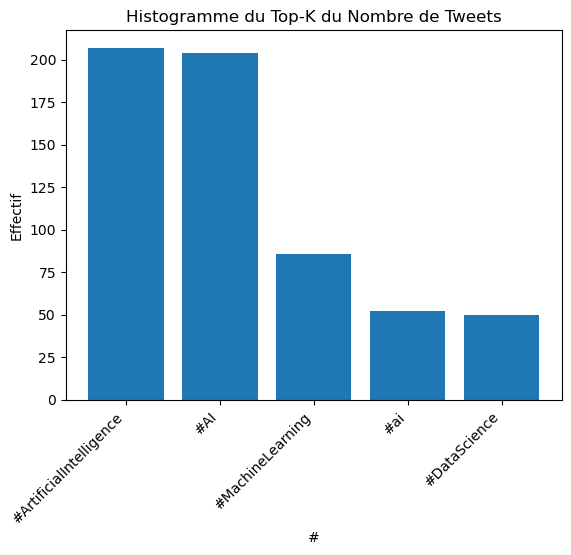

In [66]:
Inpoda(DF=DicoH.TopKH(5)).Histogramme()

# DicoH.TopKH(5) -> à partir de la variable "DicoH" de type 'Inpoda' on élabore le DataFrame contenant les # et leur effectif
# Inpoda(DF=DicoH.TopKH(5)) -> on transforme notre 'DataFrame' en 'Inpoda'
# .Histogramme() -> on utilise cet attribut de la classe 'Inpoda' pour afficher l'Histogramme

In [67]:
# Autre Exemple :
#DicoH.TopKH(5) # Affichage du 'DataFrame'

In [68]:
# Autre Exemple :
#DFP.TopKH(K=5,DicoH=DicoH.Dico)

- Top K Utilisateurs

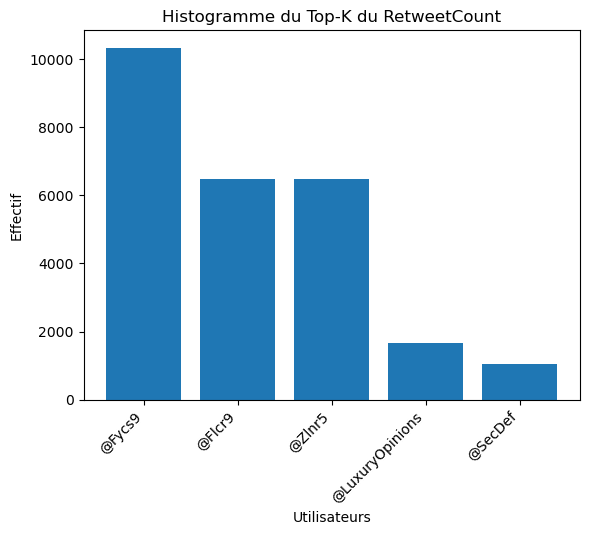

In [69]:
Inpoda(DF=DFP.TopKU(5)).Histogramme()

In [70]:
# Autre exemple :
#Inpoda(DF=(DicoA.TopKU(-8, DFP.DF))).Histogramme()

- Top K utilisateurs mentionnés

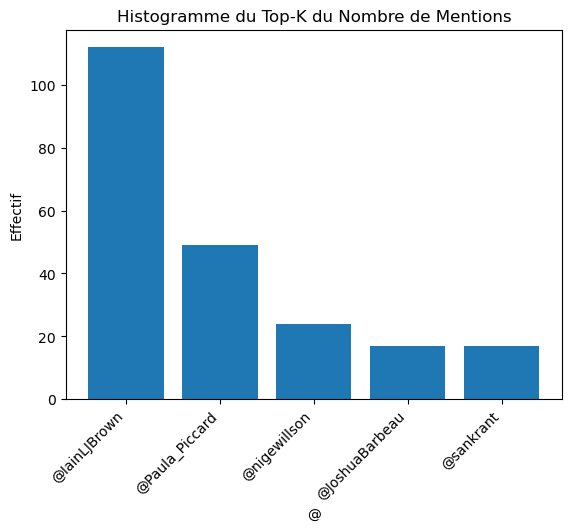

In [71]:
Inpoda(DF=DicoA.TopKA(5)).Histogramme()

In [1]:
# Autre Exemple :
#DFP.TopKA(K=5,DicoA=DicoA.Dico)

- Top K Topics

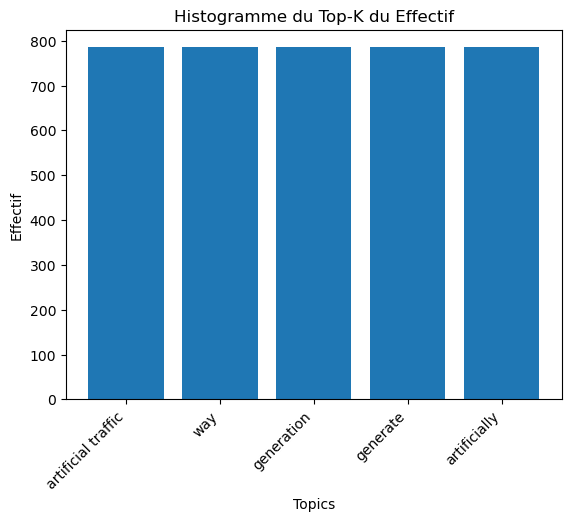

In [73]:
Inpoda(DF=DicoT.TopKT(5)).Histogramme()

# Le Nombre de publication par Utilisateur/Hashtag

- Le nombre de publications par utilisateur

In [75]:
DFP.NbPostUtilisateur(Utilisateur="@adgpi")

('@adgpi', 27)

- Le nombre de publications par hashtag

In [76]:
DicoH.NbPostHashtags(hashtag= '#AI')

('#AI', 204)

- Le nombre de publication par topic

In [77]:
DicoT.NbPostTopics(topic= 'artificially')

('artificially', 785)

# Les dernières analyses demandées

- L’ensemble de tweets d’un utilisateur spécifique

In [78]:
DFP.TweetsUtilisateur(Utilisateur="@Gizchina")

,Tweets postés par : @Gizchina
0,OPPO releases its first 6G white paper. A syst...
1,"RT @sfchronicle: “Intellectually, I know it’s ..."


- L’ensemble de tweets mentionnant un utilisateur spécifique

In [79]:
DFP.TweetsMentionUtilisateur(Utilisateur="@intratio")

,Tweets mentionnant : @intratio
75,RT @intratio: $MDVL https://t.co/rso4WTkGcW Me...
400,RT @intratio: https://t.co/GGI5g1FRD3 Kinnate ...
843,RT @intratio: $CUE https://t.co/N3KHKWvbdp Cue...


- Les utilisateurs mentionnant un hashtag spécifique

In [80]:
DFP.UtilisateurMentionHashtag(Hashtag='#AI')

,Utilisateurs
4,@nerdgirlz
8,@arXiv_Daily
10,@DecisionsSmart
42,@frontiersin
58,@TACHOUHONER
...,...
1679,@Biou5
1681,@Txxh0
1684,@Dygr3
1699,@Ickf0


- Les utilisateurs mentionnés par un utilisateur spécifique

In [81]:
DFP.UtilisateurMentionUtilsateur(Utilisateur="@xoce_q")

,@xoce_q a mentionné :
0,@codewithibrahim


# Interface Graphique de Inpoda

In [96]:
import gradio as gr

#Creation d'une liste contenant les informations du dataframe "DFP", pour pouvoir afficher les tweets par la suite
liste_data = [f"{tweet}\n\n------------------------ infos ------------------------\n"
              f"Utilisateur : {user}\nHashtags : {tags}\nUtilisateurs mentionnés : {mention}\nSentiment : {feeling}\nTopics : {topics}"
              for tweet, user, tags, mention, feeling, topics in zip(DFP.DF['TweetText'].tolist(), DFP.DF['Utilisateurs'].tolist(),
                                                            DFP.DF['#'], DFP.DF['@'], DFP.DF['Sentiment'], DFP.DF["Topics"])]


def afficher_liste():
    # Retourner le contenu de la liste sous forme de texte
    return liste_data

def afficher_hashtags(entier):
    hashtags_series = DicoH.TopKH(K=entier)['#']
    val = [f"{hashtag}" for hashtag in hashtags_series]
    tags = ', '.join(val)
    return tags

def afficher_topics(entier):
    topics_series = DicoT.TopKT(K=entier)['Topics']
    val = [f"{topic}" for topic in topics_series]
    tags = ', '.join(val)
    return tags


def afficher_arobases(entier):
    arobases_series = DFP.TopKU(K=entier)["Utilisateurs"]
    val = [f"{arobase}" for arobase in arobases_series]
    elt = ', '.join(val)
    return elt

def afficher_arobases_m(entier):
    arobases_m_series = DicoA.TopKA(K=entier)["@"]
    val = [f"{arobase}" for arobase in arobases_m_series]
    elt = ', '.join(val)
    return elt

def reception_nbpostutilisateur(user):
    nombre = DFP.NbPostUtilisateur(Utilisateur=user)[1]
    return f"L'utilisateur {user} a écrit {nombre} post(s)"

def reception_nbposthashtags(tag):
    nombre = DicoH.NbPostHashtags(hashtag=tag)[1]
    return f"Il y a {nombre} post écrit avec le hashtag {tag}"

def reception_nbposttopics(topic):
    nombre = DicoT.NbPostTopics(topic=topic)[1]
    return f"Il y a {nombre} post écrit sur le sujet : {topic}"

def reception_tweets_utilisateur(user):
    df_tweets = DFP.TweetsUtilisateur(user)
    return df_tweets

def plotH(entier):
    if type(entier) != int:
        entier = 5
    return DicoH.TopKH(K=entier)

def plotU(entier):
    if type(entier) != int:
        entier = 5
    dfU = DFP.TopKU(K=entier)
    assert type(dfU) == DataFrame
    return dfU

def plotA(entier):
    if type(entier) != int:
        entier = 5
    return DicoA.TopKA(K=entier)

def plotT(entier):
    if type(entier) != int:
        entier = 5
    return DicoT.TopKT(K=entier)


#Creation de 1708 textboxes pour y stocker les txeets
composants_texte = [gr.Textbox() for k in liste_data]

# Ici 2 blocks différents sont utilisés pour afficher les éléments de manière optimale et claire
#Le premier block se nomme iface et sert uniquement à l'affichage des 1708 tweets
with gr.Blocks() as iface:
    gr.Markdown(value="# Analyse de tweets")
    for i, elt in enumerate(composants_texte):
        txt = gr.Textbox(label=("Tweet n°"+ str(i)), value=liste_data[i])

#Le deuxième block se nomme analyse, est interactive et sert à afficher le résultats des fonctions dites secondaires c'est à dire les Top(K) et autres
with gr.Blocks() as analyse:
    gr.Markdown(value="# Analyses plus profondes sur la base de données entière")

    #Ici on fait plusieurs sous catégories, une pour chacune des fonctions

    gr.Markdown(value="## Top K hastags")
    with gr.Row():
        # Slider pour la sélection d'un nombre
        slider1 = gr.Slider(value=1,minimum=-672, maximum=672, label="Selectionnez un nombre", step=1)
        reponse1 = gr.Text(label="Les  hashtags les plus fréquents sont les suivants : ")
        reponse1B = gr.BarPlot(
            x="#",
            y="Nombre de Tweets",
            tooltip=["Nombre de Tweets","#"],
            title="Histogramme des hashtags mentionnés",
            x_title="#",
            y_title="Nombre de Tweets",
            width=350,
            height=300)
    btn1 = gr.Button("Obtenir le résultat")
    btn1B = gr.Button("Obtenir l'Histogramme")
    btn1.click(afficher_hashtags, inputs=[slider1], outputs=reponse1)
    btn1B.click(plotH, inputs=[slider1], outputs=reponse1B)

    gr.Markdown(value="## Top K @")
    with gr.Row():
        slider2 = gr.Slider(value=1,minimum=-1708, maximum=1708, label="Selectionnez un nombre", step=1)
        reponse2 = gr.Text(label="Les @ les plus fréquents sont les suivants : ")
        reponse2B = gr.BarPlot(
            x="Utilisateurs",
            y="RetweetCount",
            tooltip=["RetweetCount","Utilisateurs"],
            title="Histogramme des Utilisateurs",
            x_title="Utilisateurs",
            y_title="RetweetCount",
            width=350,
            height=300)
    btn2 = gr.Button(value = "Obtenir le résultat")
    btn2B = gr.Button(value = "Obtenir l'Histogramme")
    btn2.click(afficher_arobases, inputs=[slider2], outputs=reponse2)
    btn2B.click(plotU, inputs=[slider2], outputs=reponse2B)

    gr.Markdown(value="## Top K @ mentionnés")
    with gr.Row():
        slider3 = gr.Slider(value=1,minimum=-1085, maximum=1085, label="Selectionnez un nombre", step=1)
        reponse3 = gr.Text(label="Les @ mentionnés les plus fréquents sont les suivants : ")
        reponse3B = gr.BarPlot(
            x="@",
            y="Nombre de Mentions",
            tooltip=["Nombre de Mentions","@"],
            title="Histogramme des utilisateurs mentionnés",
            x_title="@",
            y_title="Nombre de mentions",
            width=350,
            height=300)
    btn3 = gr.Button(value = "Obtenir le résultat")
    btn3B = gr.Button(value= "Obtenir l'Histogramme")
    btn3.click(afficher_arobases_m, inputs=[slider3], outputs=reponse3)
    btn3B.click(plotA, inputs=[slider3], outputs=reponse3B)

    gr.Markdown(value="## Top K Topics mentionnés")
    with gr.Row():
        sliderT = gr.Slider(value=1,minimum=-735, maximum=735, label="Selectionnez un nombre", step=1)
        reponseT = gr.Text(label="Les  Topics les plus fréquents sont les suivants : ")
        reponseT2 = gr.BarPlot(
            x="Topics",
            y="Effectif",
            tooltip=["Effectif","Topics"],
            title="Histogramme des utilisateurs mentionnés",
            x_title="Topics",
            y_title="Effectif",
            width=350,
            height=300)
    btnT = gr.Button(value = "Obtenir le résultat")
    btnT2 = gr.Button(value = "Obtenir l'Histogramme")
    btnT.click(afficher_topics, inputs=[sliderT], outputs=reponseT)
    btnT2.click(plotT, inputs=[sliderT], outputs=reponseT2)

    gr.Markdown(value="## Nombre de publications par utilisateur")
    with gr.Row():
        users = DFP.DF["Utilisateurs"].tolist()
        dropdown1 = gr.Dropdown(users, multiselect=False, label = "Veuillez séléctionner un utilisateur")
        reponse4 = gr.Label(value= "Nombre de posts écrits par l'utilisateur mentionné ", label = "Réponse")
    btn4 = gr.Button("Obtenir le résultat")
    btn4.click(reception_nbpostutilisateur, inputs=[dropdown1], outputs=reponse4)

    gr.Markdown(value="## Nombre de publications par hashtags")
    with gr.Row():
        hashtags = DicoH.Dico.keys()
        dropdown2 = gr.Dropdown(hashtags, multiselect=False, label = "Veuillez séléctionner un hashtag")
        reponse5 = gr.Label(value= "Nombre de posts écrits pour l'hashtag mentionné ", label = "Réponse")
    btn5 = gr.Button(value = "Obtenir le résultat")
    btn5.click(reception_nbposthashtags, inputs=[dropdown2], outputs=[reponse5])

    gr.Markdown(value="## Nombre de publications par Topics") 
    with gr.Row():
        topics = DicoT.Dico.keys()
        dropdownT2 = gr.Dropdown(topics, multiselect=False, label = "Veuillez séléctionner un topic")
        reponseT2 = gr.Label(value= "Nombre de posts écrits pour le topic mentionné ", label = "Réponse")
    btnT2 = gr.Button(value = "Obtenir le résultat")
    btnT2.click(reception_nbposttopics, inputs=[dropdownT2], outputs=[reponseT2])


    gr.Markdown(value="## Ensemble de tweets de l'utilisateur entré")
    with gr.Row():
        users = DFP.DF["Utilisateurs"].tolist()
        dropdown3 = gr.Dropdown(users, multiselect=False, label = "Veuillez séléctionner un utilisateur")
        reponse6 = gr.Dataframe()
    btn6 = gr.Button(value = "Obtenir le résultat")
    btn6.click(reception_tweets_utilisateur, inputs=[dropdown3], outputs=[reponse6])


# On lance tout l'affichage par cette commande
if __name__ == "__main__":
    iface.launch() and analyse.launch()

# Remarque : l'affichage de l'interface graphique prend du temps

Running on local URL:  http://127.0.0.1:7900

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7901

To create a public link, set `share=True` in `launch()`.


# Ressources suplémentaires
Des ressources suplémentaire sont disponible sur le Github dont le lien est ci dessous. Vous y trouverez notamment un diagramme détaillant le fonctionnement de **InPoDa** ainsi que le détail de la répartition des taches.

**Github** : https://github.com/LugolBis/Projet-IN304 


# *Références*
- Chat-GPT
- Documentation de ```Pandas``` : https://pandas.pydata.org/docs/user_guide/index.html
- Documentation de ```BERTopic``` : https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html
- Models ```Hugging Face``` : https://huggingface.co/models
- Documentation de ```Gradio``` : https://www.gradio.app/docs/interface